In [4]:
from sklearn.cluster import KMeans
import numpy as np
import scipy as sp
import sys
sys.path.append('../corv/src')
sys.path.append('../wdtools')

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
import pandas as pd
import corv

### Query
from astroquery.sdss import SDSS
from astroquery.gaia import Gaia
from astropy import constants as c
import data_selector as ds
#import photoradius as pr

import wdtools
import corv


In [5]:
from astropy.table import Table, Column, MaskedColumn, join

sdss5_catalog = Table.read('data/sdss5/sdss5_catalog.fits')
nug5 = Table.read('data/sdss5/nug5.fits')

sdss5_catalog = join(sdss5_catalog, nug5, keys='wd_source_id', join_type='inner')

100%|███████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


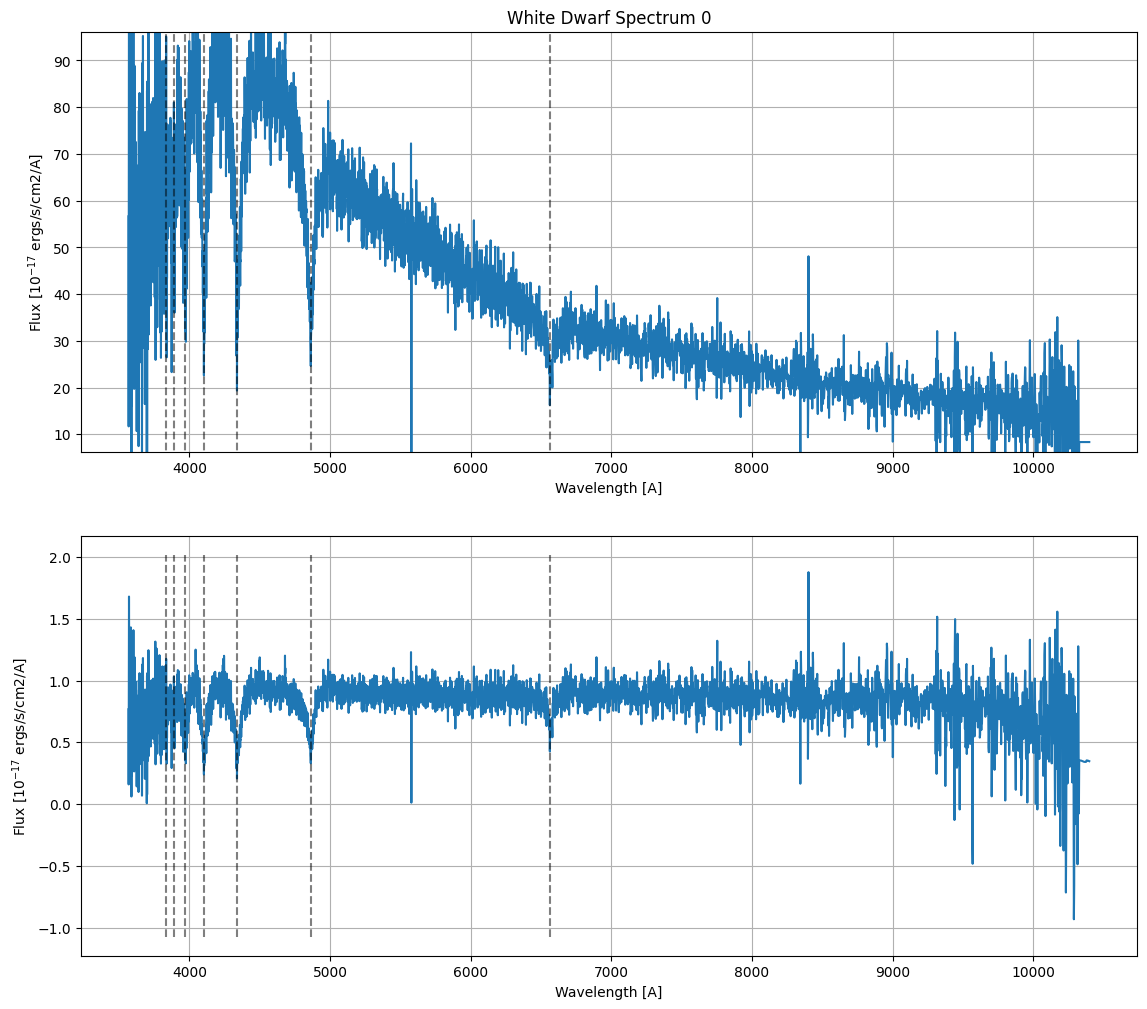

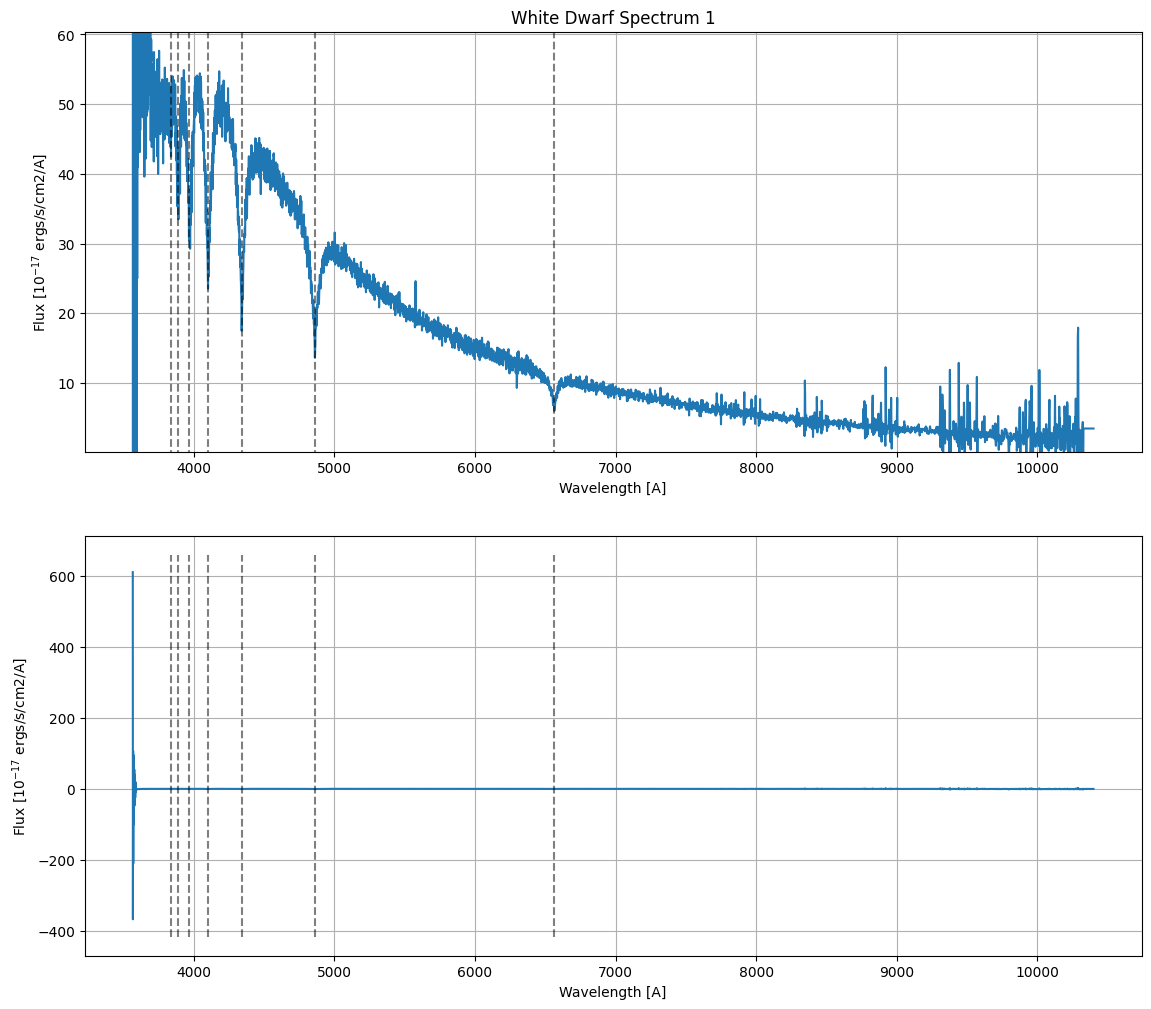

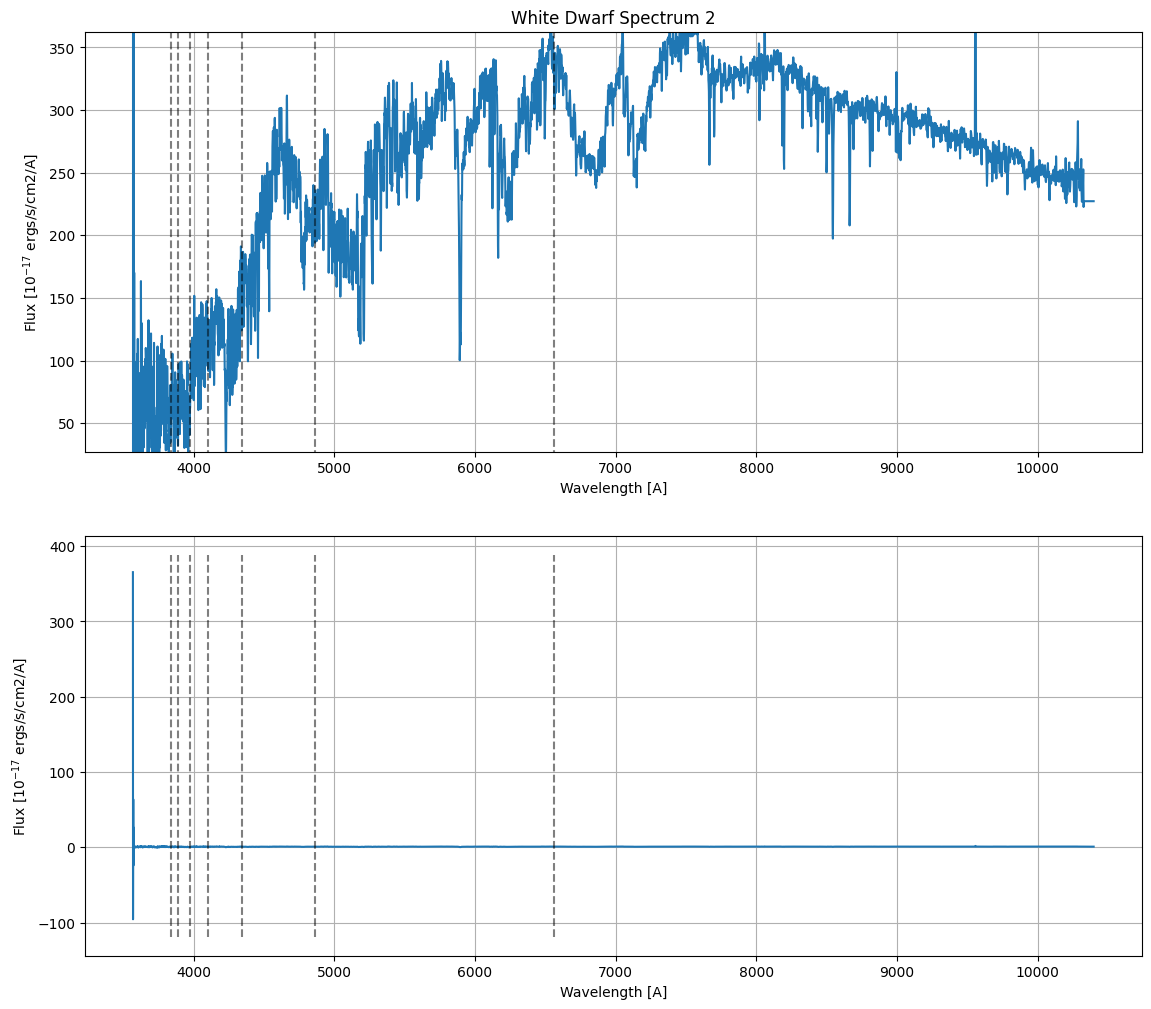

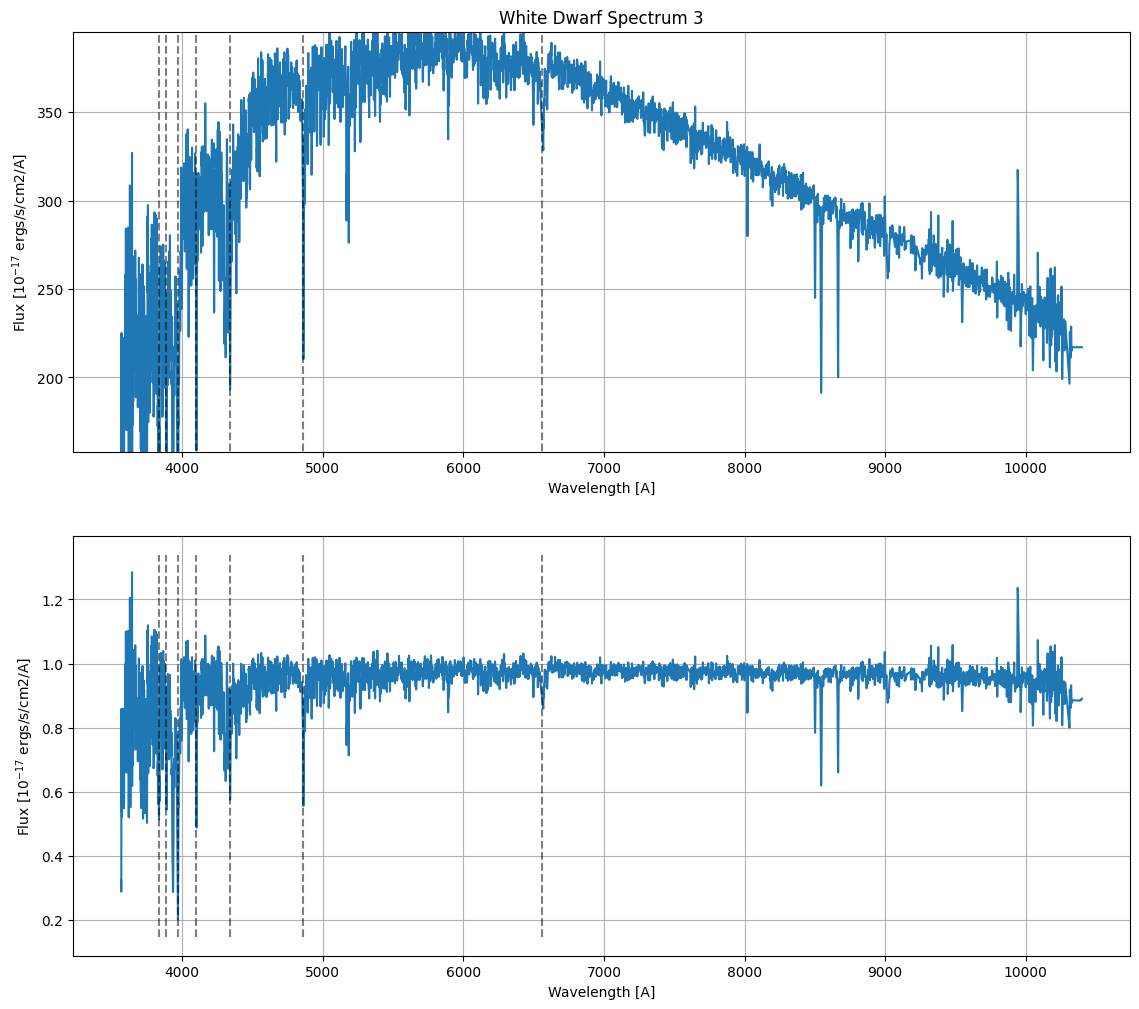

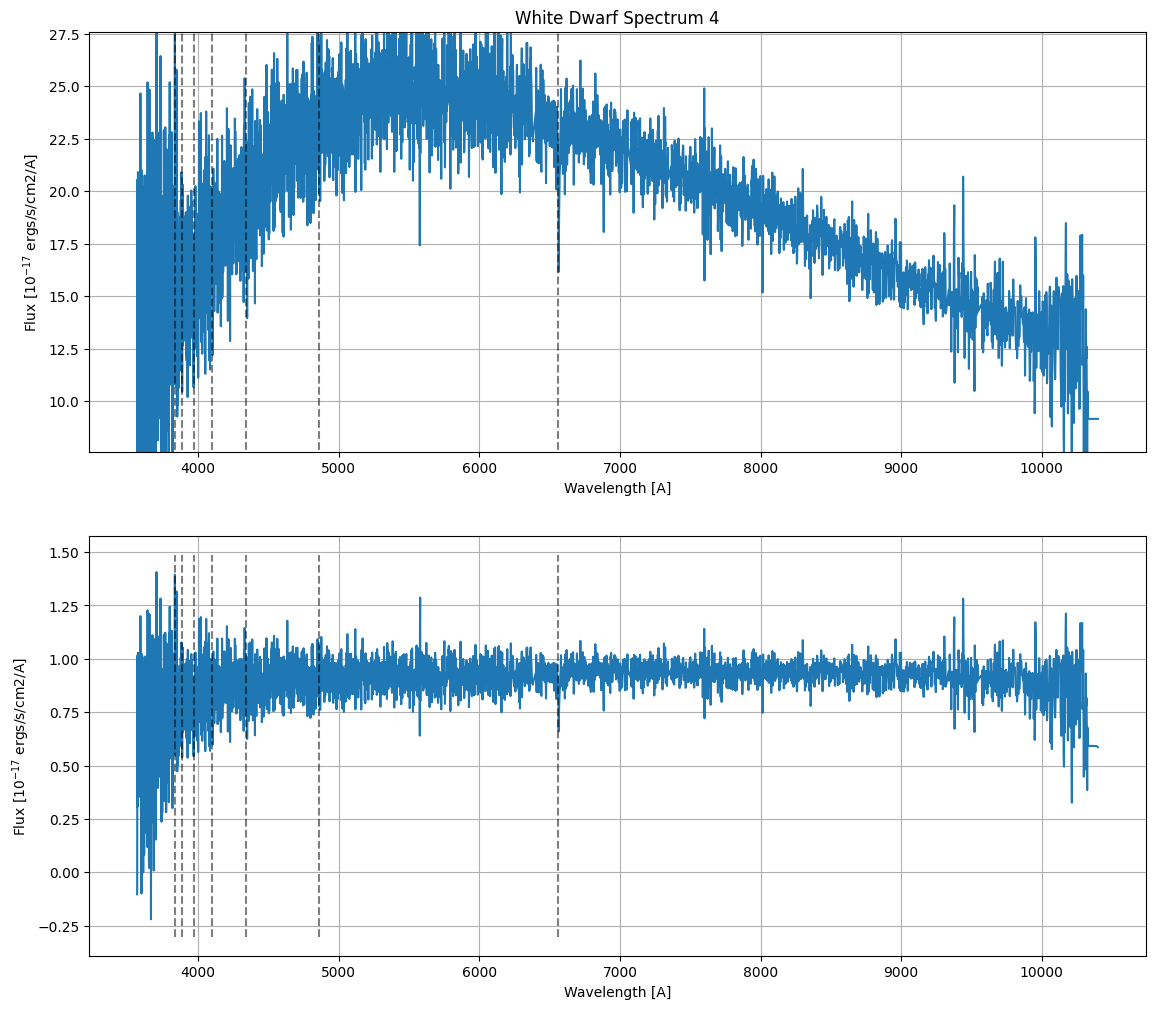

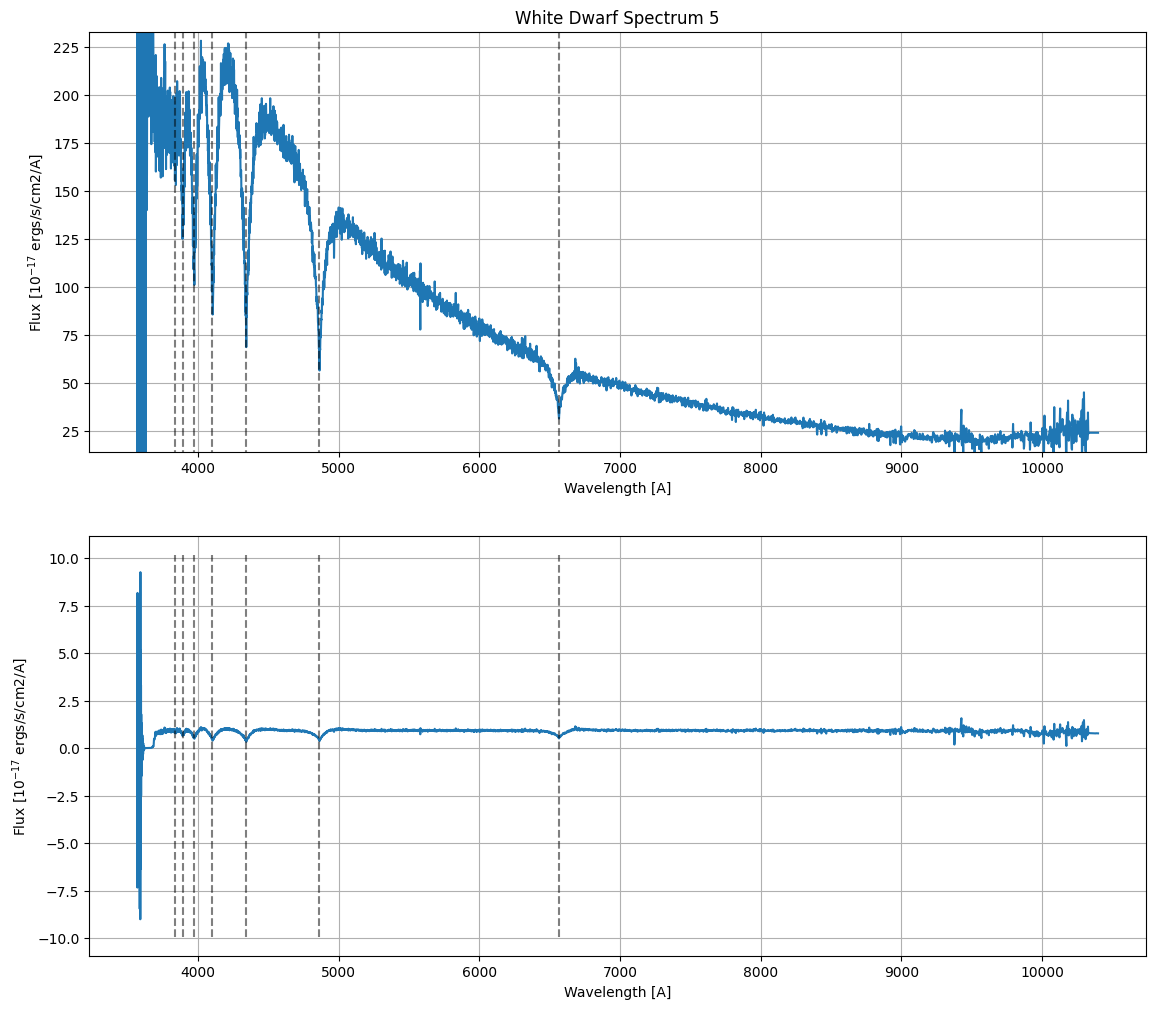

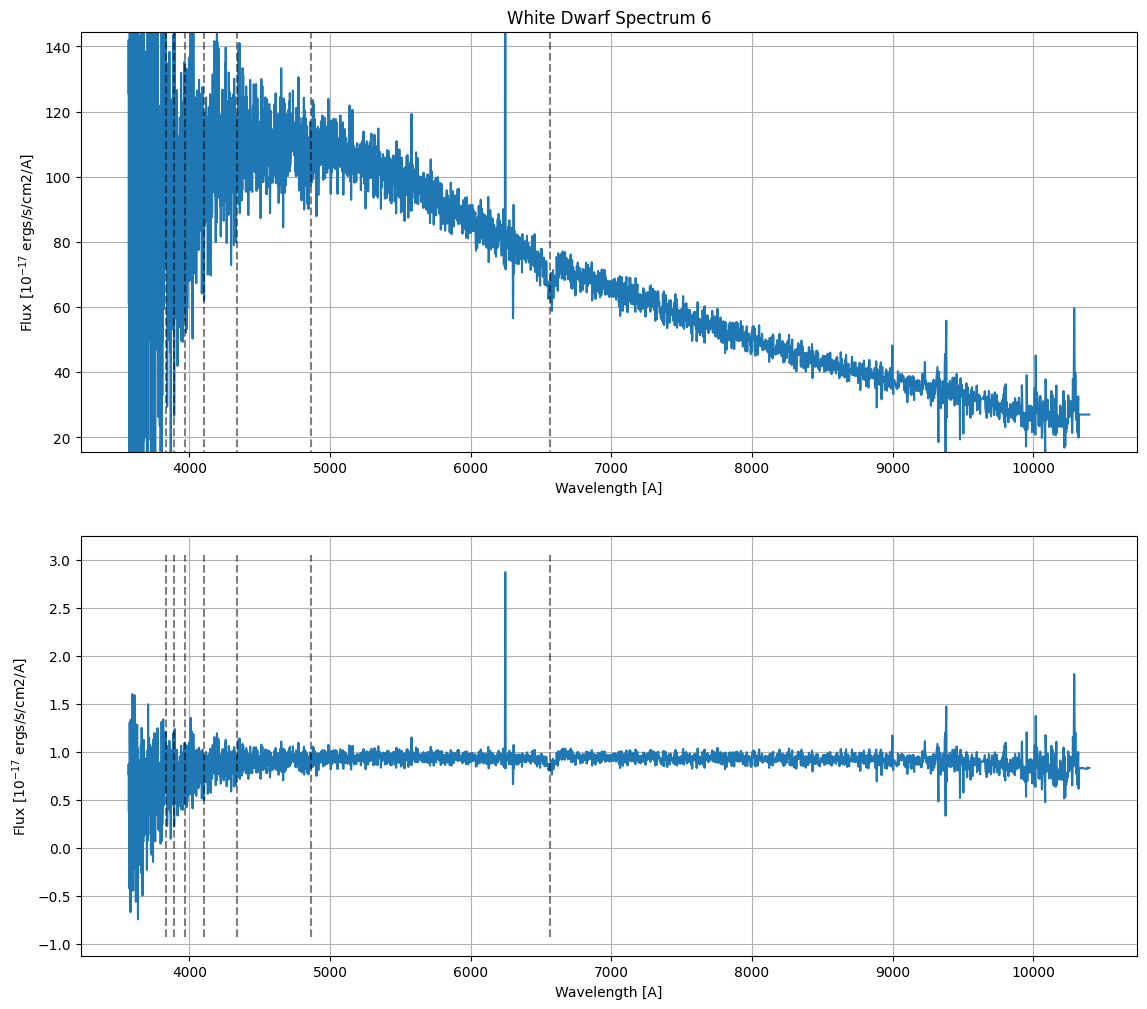

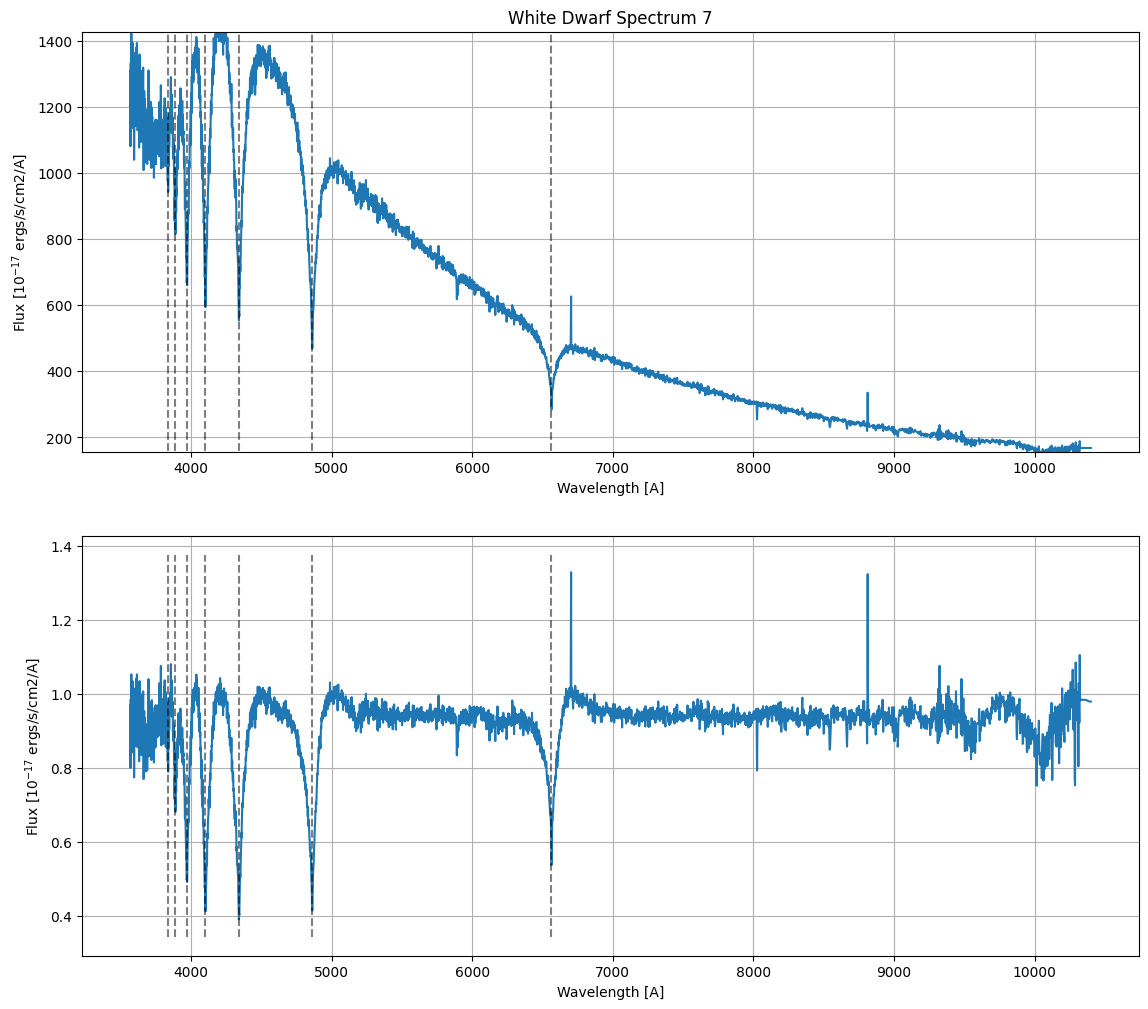

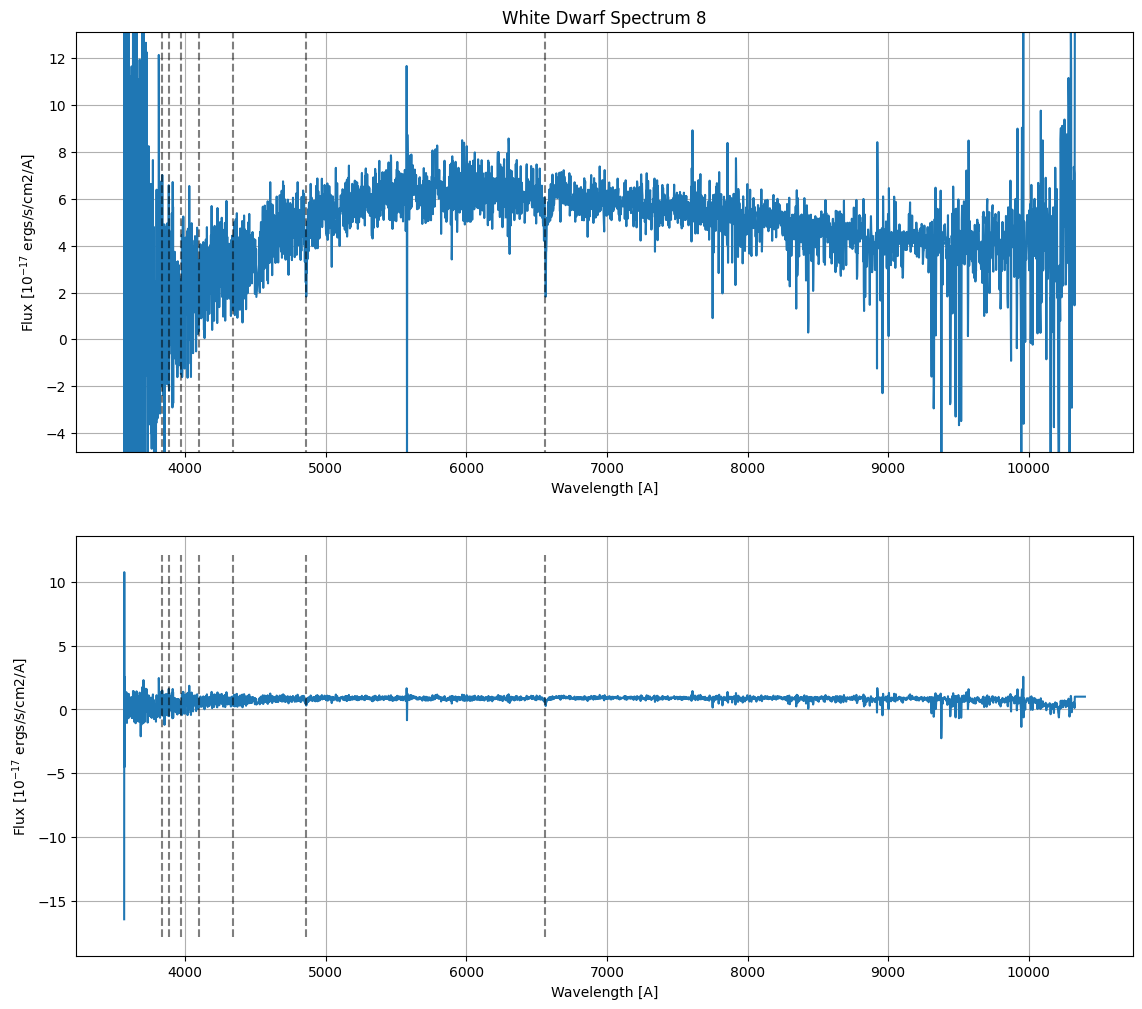

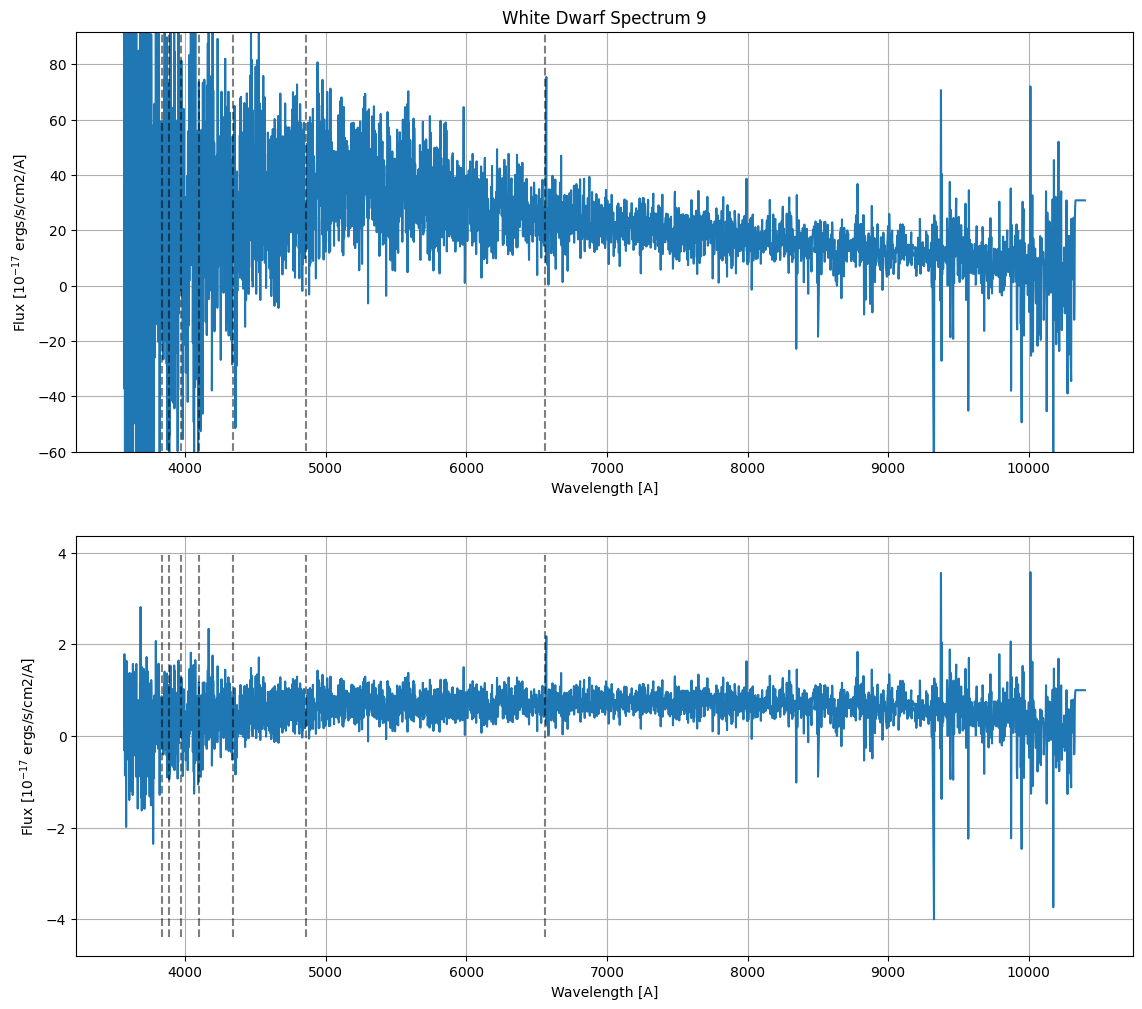

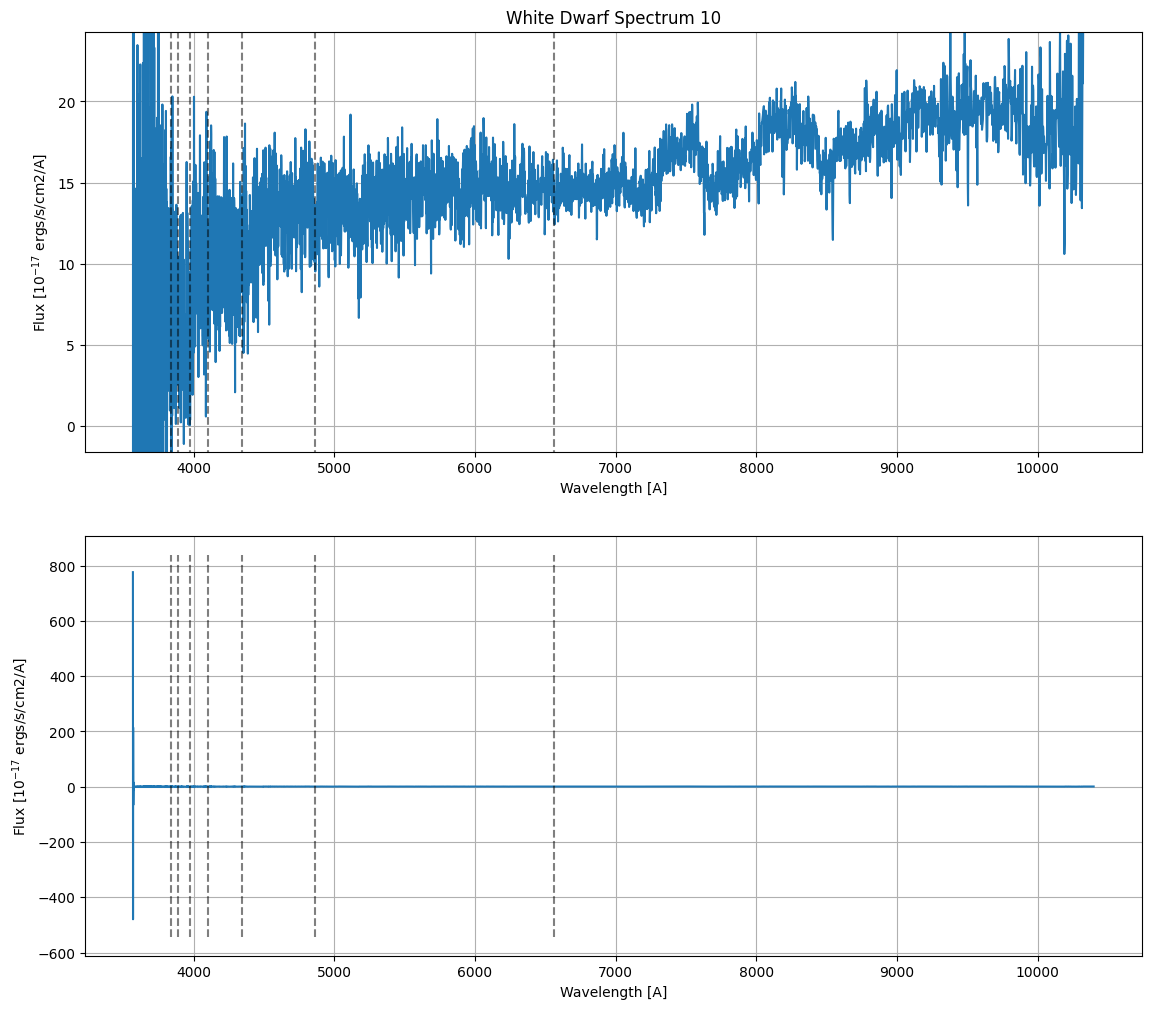

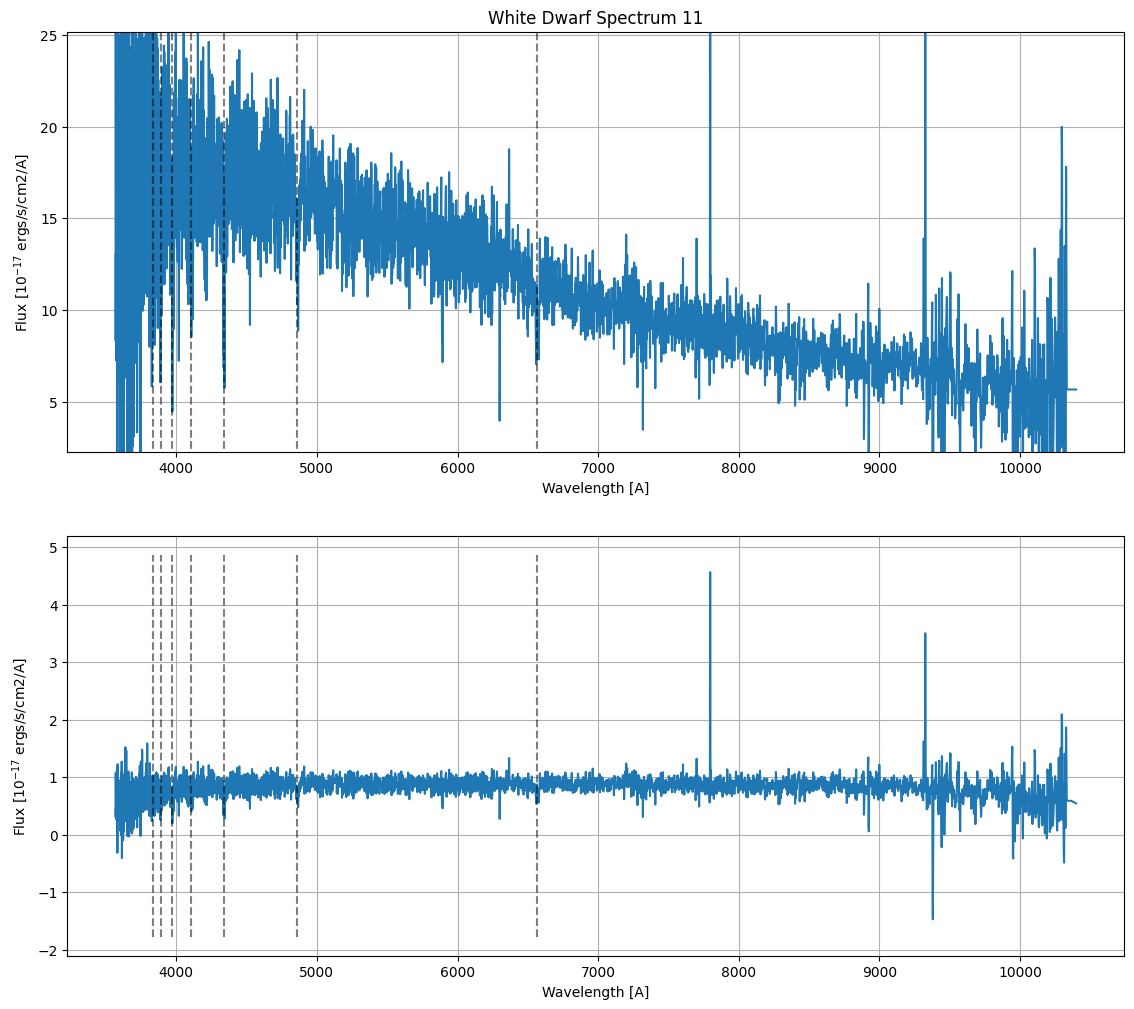

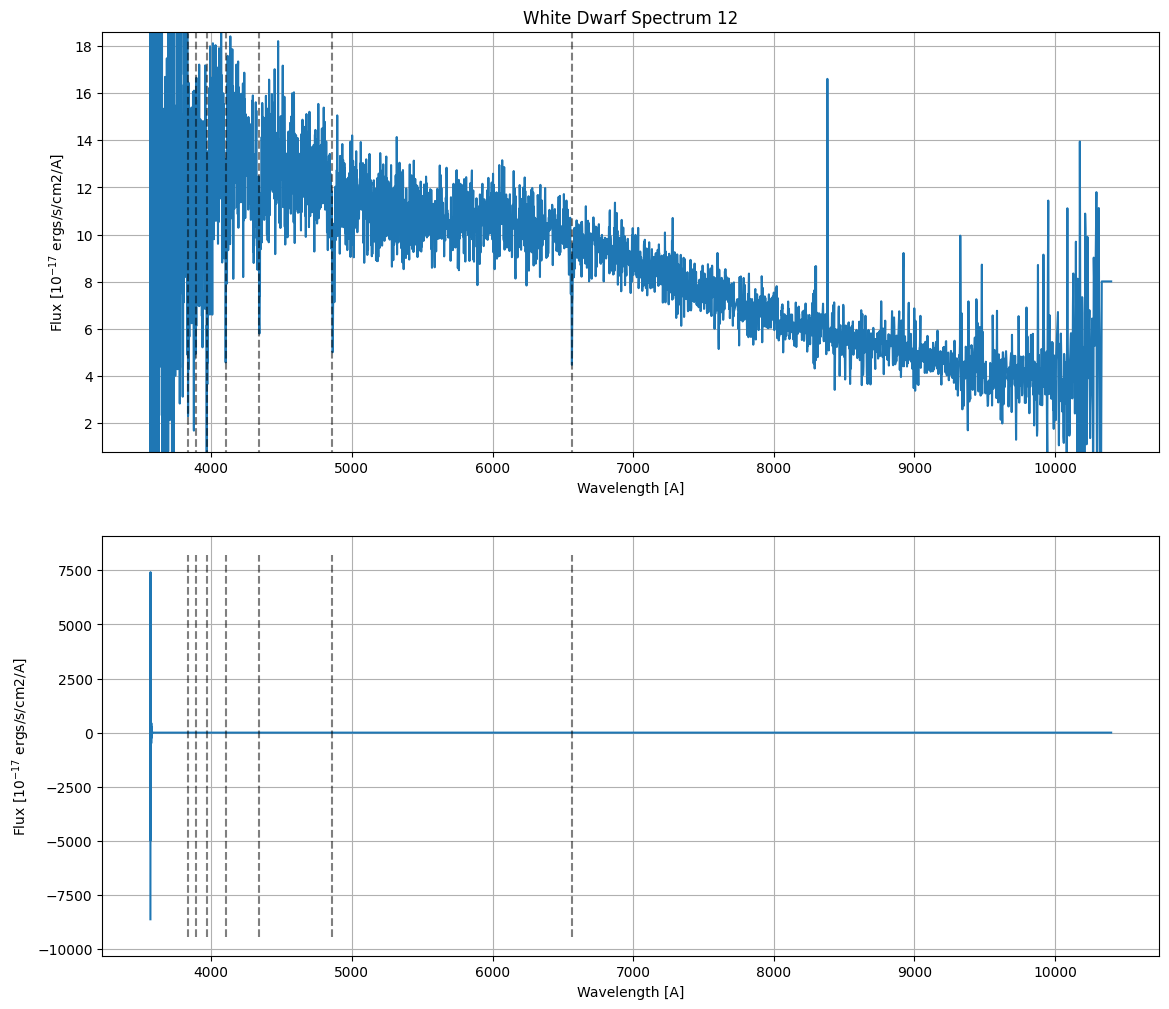

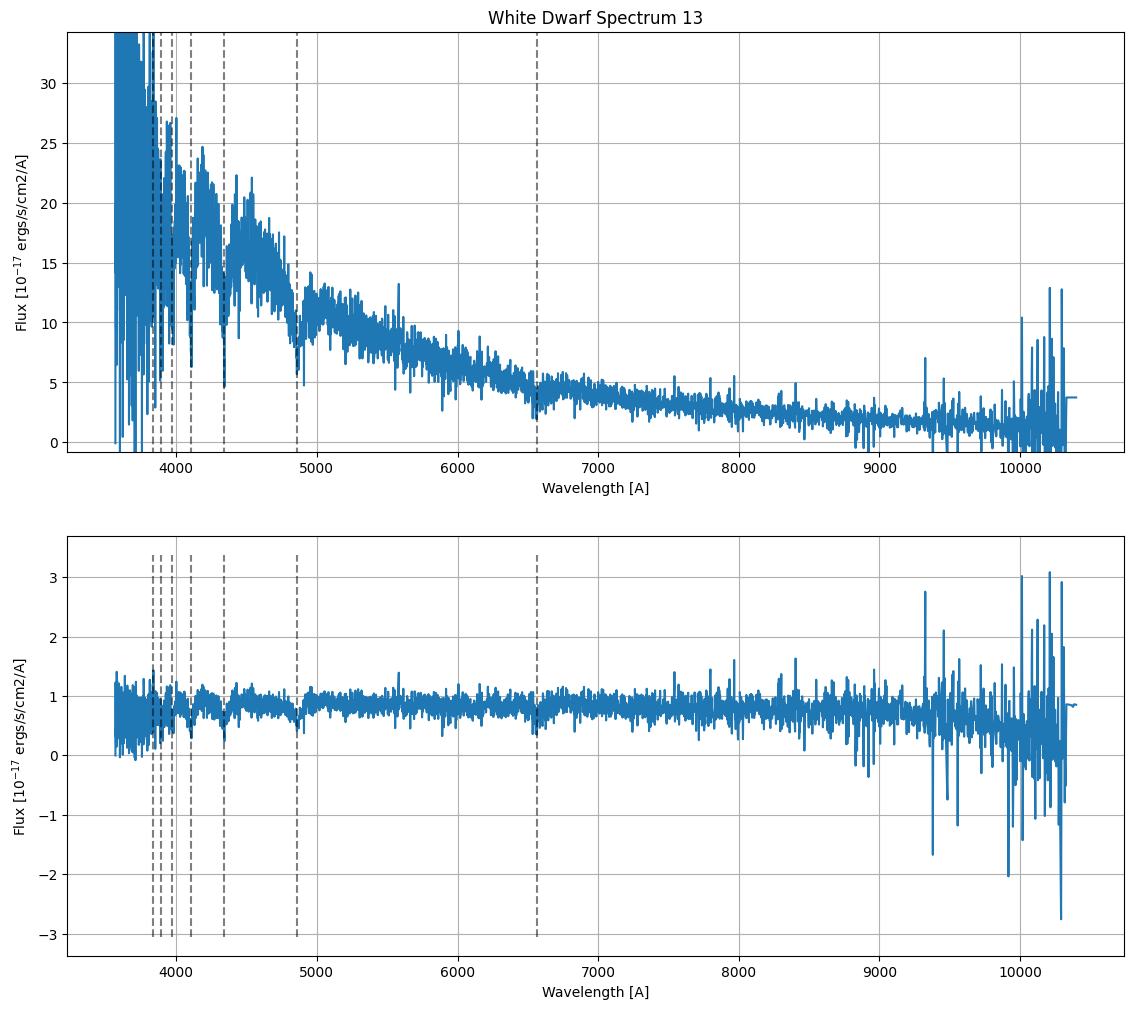

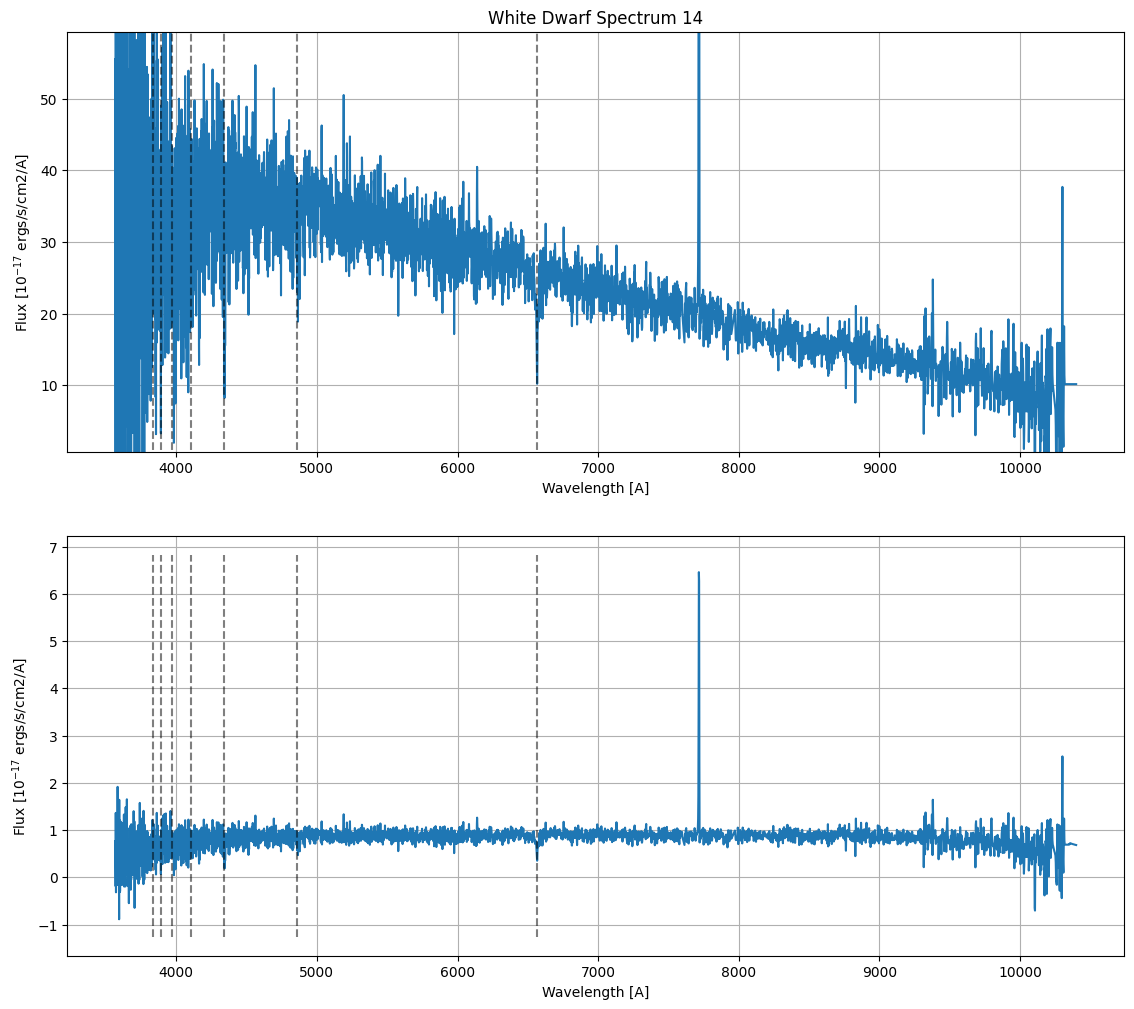

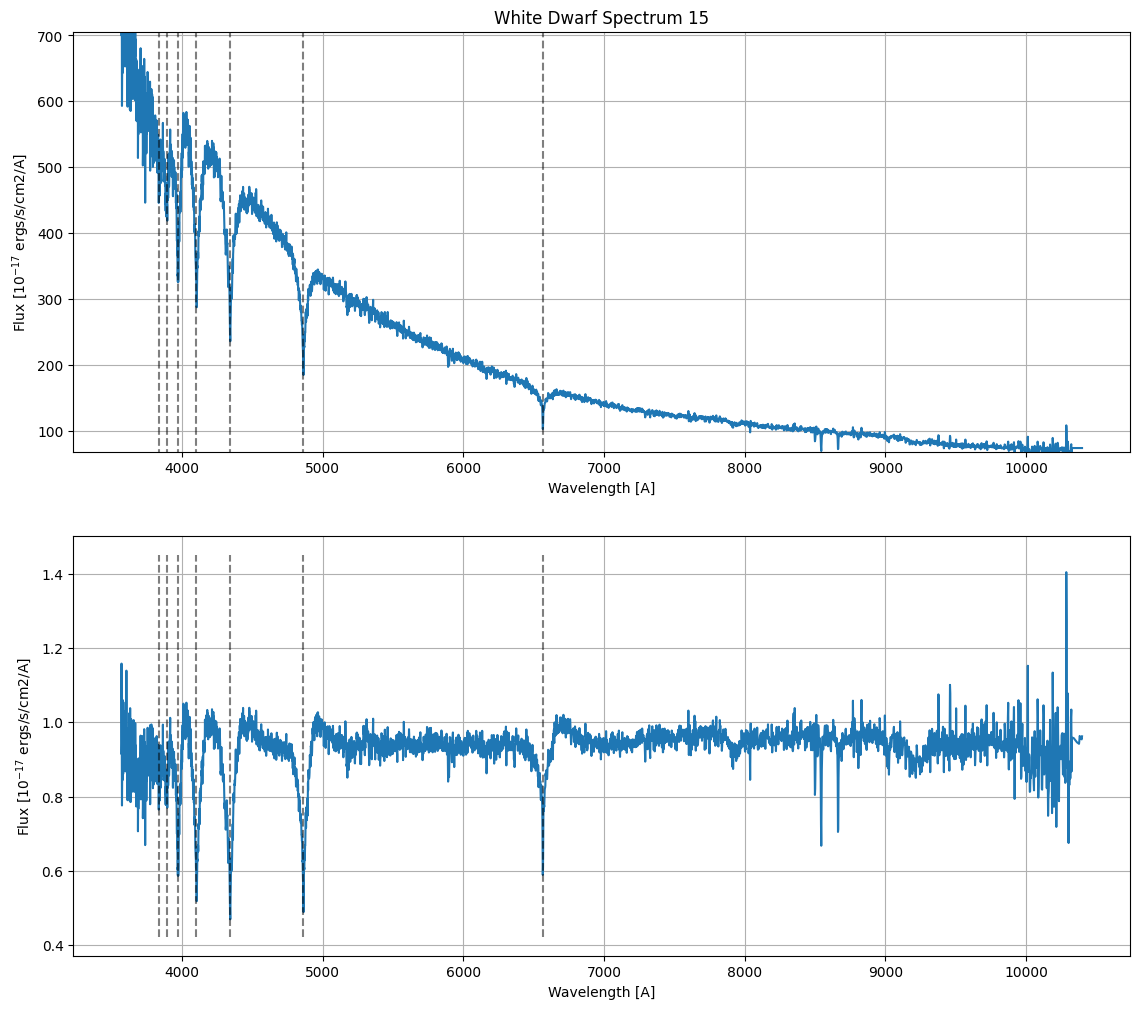

In [7]:
def pseudonormalize(fl, win = 250):
    cont_fl = np.repeat(np.nan, len(fl))
    
    for i in range(len(fl)):
        if (i - (win / 2)) < 0:
            fl_win = fl[0:(i + (win // 2))]
        else:
            fl_win = fl[(i - (win // 2)) : (i + (win // 2))]
        
        cont_fl[i] = np.percentile(fl_win, 90)
        
    return fl / cont_fl

sdss5_catalog['rv_id'] = np.ones(len(sdss5_catalog))

id_ = []
balmer_lines = [6562.79, 4861.35, 4340.47, 4101.73, 3970.07, 3889.06, 3835.40]

for i in tqdm(range(len(sdss5_catalog))):
    sdss5_catalog['rv_id'] *= i

    plt.figure(figsize=(30,12))
    
    plt.subplot(2,2,1)
    plt.plot(sdss5_catalog['wl'][i], sdss5_catalog['fl'][i])
    min_, max_ = plt.ylim()
    plt.vlines(balmer_lines, min_, max_, colors = 'black', linestyle = 'dashed', alpha = 0.5)
    plt.grid()
    plt.ylabel(r'Flux [$10^{-17}$ ergs/s/cm2/A]')
    plt.xlabel(r'Wavelength [A]')
    plt.ylim(np.percentile(sdss5_catalog['fl'][i], 1), np.percentile(sdss5_catalog['fl'][i], 99))
    plt.title('White Dwarf Spectrum {}'.format(i))
    
    plt.subplot(2,2,3)
    plt.plot(sdss5_catalog['wl'][i], pseudonormalize(sdss5_catalog['fl'][i]))
    min_, max_ = plt.ylim()
    plt.vlines(balmer_lines, min_, max_, colors = 'black', linestyle = 'dashed', alpha = 0.5)
    plt.grid()
    plt.ylabel(r'Flux [$10^{-17}$ ergs/s/cm2/A]')
    plt.xlabel(r'Wavelength [A]')
    #plt.title('White Dwarf Spectrum {}'.format(i))
    #plt.savefig('spectra/sdss4/wd{}.png'.format(i))

    


In [ ]:
#bad_spec = [1,4,5,8,10,11,13,15,16]
bad_spec = [2,3,4,6,8,9,10,11,12,13]

sdss5_catalog.remove_rows(bad_spec)

In [ ]:
from lmfit import Parameters, fit_report, minimize

calculate_rvs = True


if calculate_rvs:
    rvs = []
    e_rvs = []

    teff = []
    logg = []
    e_teff = []
    e_logg = []

    redchi = []
    drops = []
    figs = []

    return_obj = []

    #catalog['wd_ivar'] = [catalog['wd_ivar'][i]  for i in range(len(catalog))]

    for i in tqdm(range(len(sdss5_catalog))):
        #print(catalog['phot_teff'][i])
        corvmodel = corv.models.make_koester_model(names = ['a','b','g','d'])

        fl = np.array(sdss5_catalog['fl'][i])

        #for j in range(len(fl)):
        #    if fl[j] < 0:
        #        fl[j] = 0

        param_res, rv_res, rv_init = corv.fit.fit_corv(np.array(sdss5_catalog['wl'][i]), fl, np.array(sdss5_catalog['ivar'][i]), corvmodel, teff = sdss5_catalog['phot_teff'][i])
        #param_res, rv_res, rv_init = corv.fit.fit_corv(np.array(sdss5_catalog['wl'][i]), fl, np.array(sdss5_catalog['ivar'][i]), corvmodel)

        if rv_res.params['teff'].stderr == None:
            rv_res.params['teff'].stderr = 1e-6
        if rv_res.params['logg'].stderr == None:
            rv_res.params['logg'].stderr = 1e-6
        if rv_res.params['RV'].stderr == None:
            rv_res.params['RV'].stderr = 1e-6

        f = corv.utils.lineplot(np.array(sdss5_catalog['wl'][i]), np.array(sdss5_catalog['fl'][i]), np.array(sdss5_catalog['ivar'][i]), corvmodel, rv_res.params, gap = 0.3, printparams = True,
                 figsize = (6, 5))

        f.suptitle('%2.2f +/- %2.2f' % (rv_res.params['RV'].value, rv_res.params['RV'].stderr))
        figs.append(f)

        #f.savefig('spectra/corvfits/corvfit{}.jpg'.format(i))

        teff.append(rv_res.params['teff'].value)
        logg.append(rv_res.params['logg'].value)
        e_teff.append(rv_res.params['teff'].stderr)
        e_logg.append(rv_res.params['logg'].stderr)

        rvs.append(rv_res.params['RV'].value)
        e_rvs.append(rv_res.params['RV'].stderr)
        redchi.append(rv_res.redchi)

        return_obj.append(rv_res)
        
        sdss5_catalog['rv_id'][i] = i



    #catalog.remove_rows(drops)
    sdss5_catalog['rv'] = rvs
    sdss5_catalog['e_rv'] = e_rvs

    sdss5_catalog['corv_logg'] = logg
    sdss5_catalog['corv_teff'] = teff
    sdss5_catalog['e_teff'] = e_teff
    sdss5_catalog['e_logg'] = e_logg
    
    sdss5_catalog['e_rv'][sdss5_catalog['e_rv'] == None] = 1e-6
    sdss5_catalog['rechi'] = redchi
    sdss5_catalog['figs'] = figs
    
#else:
#    rv_cat = Table.read('data/wd_rvs.fits')
    
#    catalog['rv'] = rv_cat['rv']
#    catalog['e_rv'] = rv_cat['e_rv']

In [ ]:
sdss5_catalog['g_redshift'] = sdss5_catalog['rv'] - sdss5_catalog['ms_rv']
sdss5_catalog['eg_redshift'] = sdss5_catalog['ms_erv'] + sdss5_catalog['e_rv']

In [ ]:
#sdss5_catalog.remove_columns(['wl', 'fl', 'ivar'])
sdss5_catalog.remove_columns(['figs'])
sdss5_catalog.write('data/sdss5/sdss5_catalog_rvs.fits', overwrite=True)